Vision Transformer

We split an image into fixed-size patches, linearly embed each of them,
add position embeddings, and feed the resulting sequence of vectors to a standard Transformer encoder. In order to perform classification, we use the standard approach of adding an extra learnable "classification token" to the sequence. 

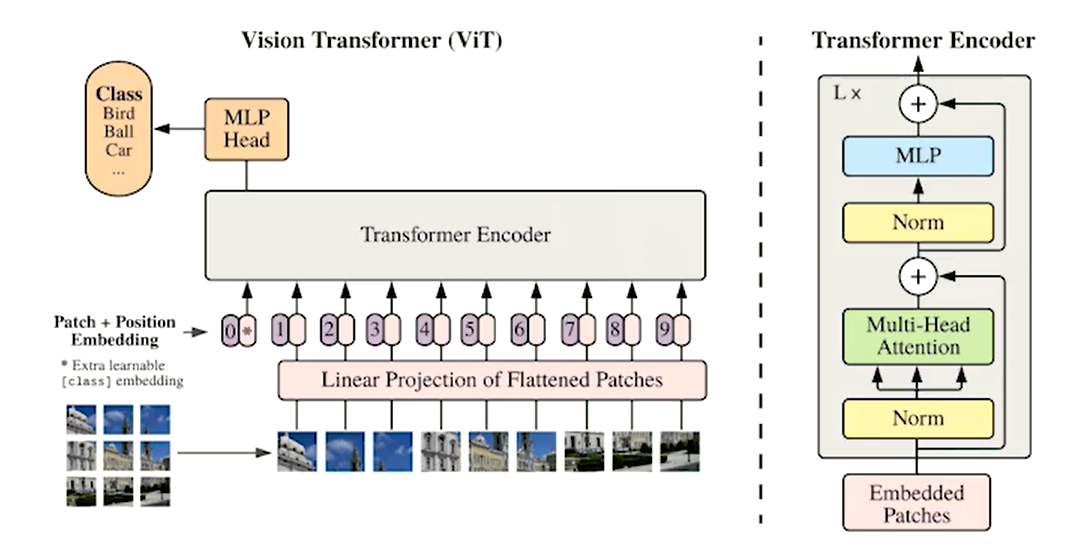

In [2]:
from transformers import ViTModel, AutoFeatureExtractor
from PIL import Image

In [3]:
vt_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

vt_model

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [4]:
feature_extractor = AutoFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
feature_extractor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

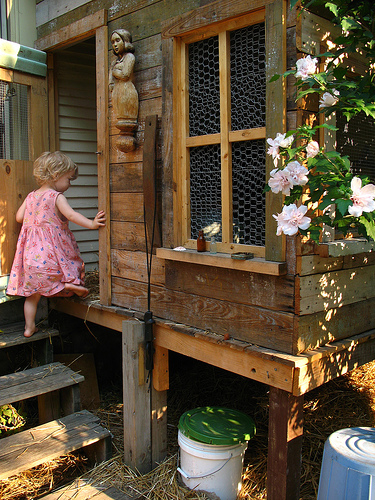

In [5]:
Image.open('/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg')

In [6]:
print(feature_extractor(Image.open('/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg')).pixel_values[0].shape)
feature_extractor(Image.open('/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg'))

(3, 224, 224)


{'pixel_values': [array([[[-0.35686272, -0.12941176, -0.09019607, ..., -0.96862745,
         -0.9529412 , -0.9529412 ],
        [-0.38039213, -0.11372548, -0.06666666, ..., -0.9372549 ,
         -0.94509804, -0.90588236],
        [-0.3960784 , -0.08235294, -0.05098039, ..., -0.9372549 ,
         -0.94509804, -0.92156863],
        ...,
        [ 0.45882356,  0.17647064,  0.3411765 , ...,  0.6627451 ,
          0.2941177 ,  0.2941177 ],
        [ 0.3803922 ,  0.38823533,  0.7254902 , ...,  0.64705884,
          0.3176471 ,  0.3176471 ],
        [ 0.62352943,  0.6392157 ,  0.4666667 , ...,  0.60784316,
          0.30980396,  0.32549024]],

       [[-0.31764704,  0.00392163,  0.05098045, ..., -0.9764706 ,
         -0.9529412 , -0.9372549 ],
        [-0.34117645,  0.01176476,  0.082353  , ..., -0.92941177,
         -0.92156863, -0.8352941 ],
        [-0.38039213,  0.03529418,  0.10588241, ..., -0.92941177,
         -0.8980392 , -0.827451  ],
        ...,
        [-0.15294117, -0.372549  , -

(3, 224, 224)
(224, 224, 3)


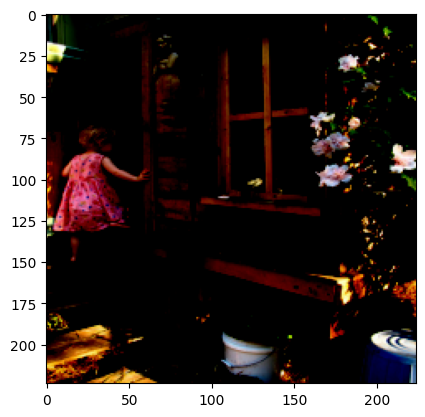

In [7]:
import matplotlib.pyplot as plt

print(feature_extractor(Image.open('/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg')).pixel_values[0].shape)
print(feature_extractor(Image.open('/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg')).pixel_values[0].transpose(1,2,0).shape)
plt.imshow(feature_extractor(Image.open('/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg')).pixel_values[0].transpose(1,2,0))

#### Fine-tuning an image captioning system

In [8]:
from transformers import VisionEncoderDecoderModel,GPT2TokenizerFast, AutoFeatureExtractor,AutoTokenizer, Trainer,TrainingArguments
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from torchvision.transforms import Compose,Normalize,ToTensor,Resize,RandomResizedCrop

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from datasets import Dataset

import requests
from io import BytesIO

In [9]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
        'google/vit-base-patch16-224-in21k',
        'distilgpt2'
        )

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.0.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.5.ln_cross_attn.bias', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.4.crossattention.q_attn.bias', 'transformer.h.0.crossattention.c_attn.bias', 'transformer.h.5.crossattention.c_attn.bias', 'transformer.h.3.ln_cross_attn.bias', 'transformer.h.4.crossattention.c_proj.bias', 'transformer.h.2.crossattention.c_proj.bias', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.4.crossattention.c_attn.weight', 'transformer.h.4.crossattention.q_attn.weight', 'transformer.h.4.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.4.crossattention.c_proj.weight', 'transformer.h.

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [10]:
type(model.encoder),type(model.decoder)

(transformers.models.vit.modeling_vit.ViTModel,
 transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel)

In [11]:
IMAGES_PATH = '/kaggle/input/flickr8k/Images'

MIN_CAPTION, MAX_CAPTION = 10,50

def load_captions_data(filename):
  with open(filename) as caption_file:
    caption_data = caption_file.readlines()    
    caption_mapping = {}
    text_data = []
    for line in caption_data[1:]:               
          line = line.rstrip("\n")                      
          # Image name and captions are separated using a ,
          img_name,caption = line.split(',', 1)
          img_name = os.path.join(IMAGES_PATH, img_name.strip())                    

          if img_name.endswith("jpg"):
            caption = caption.replace('.', '').strip()            
            tokens = caption.strip().split()
            if len(caption) < MIN_CAPTION or len(caption) > MAX_CAPTION:                
                  continue            
            text_data.append(caption)

            if img_name in caption_mapping:
                  caption_mapping[img_name].append(caption)
            else:
                  caption_mapping[img_name] = [caption]

                               
    return caption_mapping,text_data        

caption_mapping,text_data = load_captions_data('/kaggle/input/flickr8k/captions.txt')

In [12]:
list(caption_mapping.items())[:5]

[('/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
  ['A girl going into a wooden building',
   'A little girl climbing into a wooden playhouse',
   'A little girl climbing the stairs to her playhouse']),
 ('/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
  ['A black dog and a spotted dog are fighting',
   'Two dogs on pavement moving toward each other']),
 ('/kaggle/input/flickr8k/Images/1003163366_44323f5815.jpg',
  ['A man lays on a bench while his dog sits by him',
   'A shirtless man lies on a park bench with his dog']),
 ('/kaggle/input/flickr8k/Images/1007129816_e794419615.jpg',
  ['A man in an orange hat starring at something',
   'A man wears an orange hat and glasses']),
 ('/kaggle/input/flickr8k/Images/1007320043_627395c3d8.jpg',
  ['A child playing on a rope net', 'A little girl climbing on red roping'])]

In [13]:
feature_extractor = AutoFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
feature_extractor

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [14]:
print(feature_extractor.size)
size_tuple = (feature_extractor.size['height'], feature_extractor.size['width'])
size_tuple

{'height': 224, 'width': 224}


(224, 224)

In [15]:
normalize = Normalize(mean =feature_extractor.image_mean, 
                      std=feature_extractor.image_std
                     )

_transforms = Compose(
    [
        RandomResizedCrop(size_tuple),
        ToTensor(),
        normalize
    ]
)

In [16]:
rows = []

for path,captions in caption_mapping.items():
    for caption in captions:
        rows.append({'path':path,'caption':caption})

image_df = pd.DataFrame(rows)        

image_dataset = Dataset.from_pandas(image_df)

image_df.shape

(19497, 2)

In [17]:
image_df.head()

,path,caption
0,/kaggle/input/flickr8k/Images/1000268201_693b0...,A girl going into a wooden building
1,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl climbing into a wooden playhouse
2,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl climbing the stairs to her playh...
3,/kaggle/input/flickr8k/Images/1001773457_577c3...,A black dog and a spotted dog are fighting
4,/kaggle/input/flickr8k/Images/1001773457_577c3...,Two dogs on pavement moving toward each other


In [18]:
image_dataset

Dataset({
    features: ['path', 'caption'],
    num_rows: 19497
})

In [19]:
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained('distilgpt2')
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

def image_preprocessor(data):
    data['pixel_values'] = [_transforms(Image.open(path)) for path in data['path']]
    tokenized = gpt2_tokenizer(
        data['caption'], padding='max_length', max_length=10, truncation=True
    )
    data['labels'] = [[x if x != gpt2_tokenizer.pad_token_id else -100 for x in t] for t in tokenized['input_ids']]

    del data['path']
    del data['caption']

    return data

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [20]:
image_dataset = image_dataset.map(image_preprocessor,batched=True)

  0%|          | 0/20 [00:00<?, ?ba/s]

In [21]:
image_dataset = image_dataset.train_test_split(test_size=0.1)

In [23]:
image_dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 17547
    })
    test: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 1950
    })
})

In [24]:
model.config.pad_token = gpt2_tokenizer.pad_token
model.config.pad_token_id = gpt2_tokenizer.pad_token_id

model.config.decoder_start_token = gpt2_tokenizer.bos_token
model.config.decoder_start_token_id = gpt2_tokenizer.bos_token_id

In [25]:
for name,params in model.encoder.named_parameters():
    if 'encoder.layer.10' in name:
        break
    params.requires_grad = False

In [26]:
print(model.config)

VisionEncoderDecoderConfig {
  "decoder": {
    "_name_or_path": "distilgpt2",
    "_num_labels": 1,
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 50256,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "embd_pdrop": 0.1,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 50256,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "id2label": {
      "0": "LABEL_0"
    },
    "initializer_range": 0.02,
    "is_decoder": true,
    "is_encoder_decoder": false,
    "label2id": {
      "LABEL_0": 0
    },
    "layer_norm_epsilon": 1e-05,
    "length_penalty": 1.0,

In [27]:
training_args = TrainingArguments(
                output_dir="./viT_image_captions", 
                overwrite_output_dir=True,
                num_train_epochs=2,
                log_level='info',
                per_device_train_batch_size=64,
                per_device_eval_batch_size=64,                
                logging_steps=50,
                load_best_model_at_end=True,
                evaluation_strategy='epoch',
                save_strategy='epoch'                    
                )

trainer = Trainer(
            model=model,
            args=training_args,               
            train_dataset=image_dataset['train'],
            eval_dataset=image_dataset['test']
            )

trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1950
  Batch size = 128
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'eval_loss': 5.0678277015686035,
 'eval_runtime': 314.1676,
 'eval_samples_per_second': 6.207,
 'eval_steps_per_second': 0.051}

In [28]:
trainer.train()

***** Running training *****
  Num examples = 17,547
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Training with DataParallel so batch size has been adjusted to: 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 276
  Number of trainable parameters = 110,863,872
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,3.230400,2.925797
2,2.887100,2.836324


***** Running Evaluation *****
  Num examples = 1950
  Batch size = 128
Saving model checkpoint to ./viT_image_captions/tmp-checkpoint-138
Configuration saved in ./viT_image_captions/tmp-checkpoint-138/config.json
Configuration saved in ./viT_image_captions/tmp-checkpoint-138/generation_config.json
Removed shared tensor {'decoder.lm_head.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading
Model weights saved in ./viT_image_captions/tmp-checkpoint-138/pytorch_model.bin
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1950
  Batch size = 128
Saving model checkpoint to ./viT_image_captions/tmp-checkpoint-276
Configuration saved in ./viT_image_captions/tmp-ch

TrainOutput(global_step=276, training_loss=3.1284918301347373, metrics={'train_runtime': 6237.6626, 'train_samples_per_second': 5.626, 'train_steps_per_second': 0.044, 'total_flos': 4.5357114439552205e+18, 'train_loss': 3.1284918301347373, 'epoch': 2.0})

In [43]:
inference_transforms = Compose(
                                [
                                    Resize(size_tuple),
                                    ToTensor(),
                                    normalize
                                ]
                            )

In [52]:
def caption_image(model, path):    
    if 'http' in path:
        response = requests.get(path)        
        img = Image.open(BytesIO(response.content))        
    else:
        img = Image.open(path)

    image_matrix = inference_transforms(img).unsqueeze(0)
    model.to('cuda')
    image_matrix = image_matrix.to('cuda')


    generated = model.generate(
        image_matrix,        
        max_length=15,
        early_stopping=True,
        do_sample=True,
        top_k=10,
        num_return_sequences=5
      )

    caption_options = [gpt2_tokenizer.decode(g, skip_special_tokens=True).strip() for g in generated]
    display(img)
    return caption_options, generated, image_matrix


Generate config GenerationConfig {
  "decoder_start_token_id": 50256,
  "pad_token_id": 50256
}



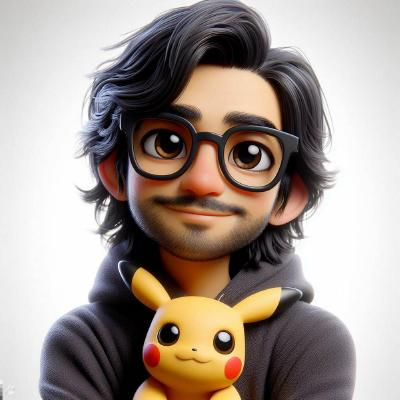

(['A young child is jumping through a large crowd of children on a swing',
  'A girl holding a camera on a swing and jumping on the swing on',
  'A child wearing a red sweater and a red shirt is playing basketball in',
  "The young man holds up a sign reading 'A woman is going on",
  'A little girl in red is playing with a toy on the couch in'],
 tensor([[50256,    32,  1862,  1200,   318, 14284,   832,   257,  1588,  4315,
            286,  1751,   319,   257,  9628],
         [50256,    32,  2576,  4769,   257,  4676,   319,   257,  9628,   290,
          14284,   319,   262,  9628,   319],
         [50256,    32,  1200,  5762,   257,  2266, 35685,   290,   257,  2266,
          10147,   318,  2712,  9669,   287],
         [50256,   464,  1862,   582,  6622,   510,   257,  1051,  3555,   705,
             32,  2415,   318,  1016,   319],
         [50256,    32,  1310,  2576,   287,  2266,   318,  2712,   351,   257,
          13373,   319,   262, 18507,   287]], device='cuda:0'),
 te

In [53]:
caption_image(model,'https://avatars.githubusercontent.com/u/48130024?s=400&u=f499569256fe7eef2fdf80a9dcd81fca868db675&v=4')

Generate config GenerationConfig {
  "decoder_start_token_id": 50256,
  "pad_token_id": 50256
}



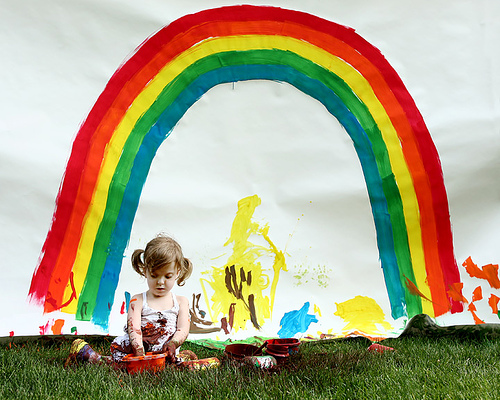

['A boy plays in a park on a blue grassy hillside near',
 'A small girl is walking in a field with her backpack in her mouth',
 'A boy is playing with his hands up by a green fence outside his',
 'A boy is holding a stick from a tree stump down a hill with',
 'a little boy is walking up a fence in one hand and the other']

In [54]:
captions,generated,image_matrix = caption_image(model,'/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg')
captions

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=510x680 at 0x7AE4EA76CA90>


Generate config GenerationConfig {
  "decoder_start_token_id": 50256,
  "pad_token_id": 50256
}



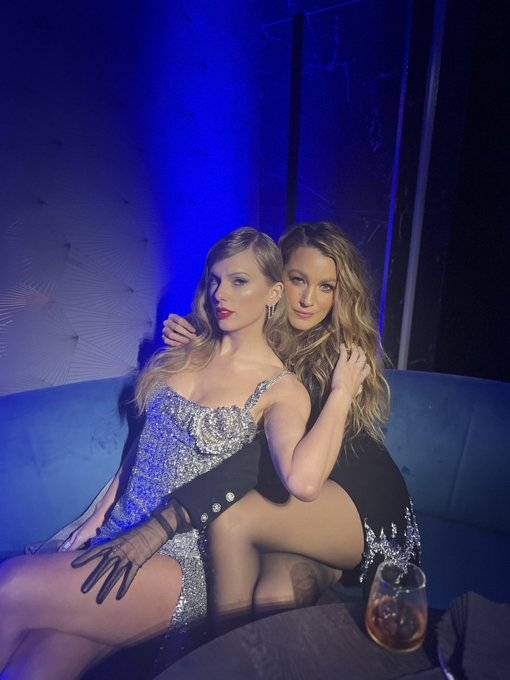

['A young girl in a dress is playing a guitar at the gym in',
 'People are walking through a large crowd of people dressed as people in costumes',
 'A girl in blue shorts and sunglasses is in a field of flowers and',
 'A woman in a red shirt is wearing a blue collar and a red',
 'A woman and a man stand near a fountain fountain with a hand on']

In [64]:
response = requests.get('https://i.postimg.cc/MKsnstwx/image.png') 
img = Image.open(BytesIO(response.content))
print(img)
caption_image(model,'https://i.postimg.cc/MKsnstwx/image.png')[0]